**BVM Hands-On Tutorial (Part 2/2)**

In this second part of the  tutorial, we will demonstrate how to use PyTorch's autograd engine to register medical images.

Let's again add all imports and mount the Google drive for data storage:

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import ConstantPad3d as Pad
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display
import time


from google.colab import drive
import tarfile

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


If run for the first time, you need to extract the data on the Google drive:

In [0]:
tar = tarfile.open(name='/content/drive/My Drive/Task02_Heart.tar', mode='r')
tar.extractall()
tar.close()

Chose two images from the Heart dataset. One will be the *fixed*  image and the other one will be the *moving* image that should be transformed in a way that it resembles the *fixed* image. However, its transformation should be plausible, i.e. especially in the medical case e.g. folding should be prohibited.
In order to achieve this, the following cells will guide you.
First, we load our image data. The label data will later be used to evaluate the transformation - to check if the segmented structures align better after registration.

In [0]:
# just a copied helper function from the last notebook...
# used to downscale the 3D volumes
class Scale(object):
  """Scale tensors spatially."""

  def __init__(self, width=1, height=1, depth=1):
    assert width or height or depth
    self.width = width
    self.height = height
    self.depth = depth

  def __call__(self, sample):
    sample['image'] = F.interpolate(
      sample['image'],
      scale_factor=(self.depth, self.height, self.width),
      mode='trilinear'
    )

    sample['label'] = F.interpolate(
      sample['label'].float(),
      scale_factor=(self.depth, self.height, self.width),
      mode='nearest'
    ).long()

    return sample

In [4]:
# load the image files 
with torch.no_grad():
  data_base_path = '/content/Task02_Heart'

  fixed_image_path = data_base_path + '/imagesTr/la_007.nii.gz'
  fixed_label_path = data_base_path + '/labelsTr/la_007.nii.gz'

  moving_image_path = data_base_path + '/imagesTr/la_023.nii.gz'
  moving_label_path = data_base_path + '/labelsTr/la_023.nii.gz'

  fixed_image = nib.load(fixed_image_path).get_data()
  fixed_label = nib.load(fixed_label_path).get_data()

  moving_image = nib.load(moving_image_path).get_data()
  moving_label = nib.load(moving_label_path).get_data()

  # as in the first part of the tutorial, we switch axes and add channel & batch
  # dimensions to our tensors

  fixed_image = torch.from_numpy(fixed_image).permute(2,1,0).unsqueeze(0).unsqueeze(0)
  fixed_label = torch.from_numpy(fixed_label).permute(2,1,0).unsqueeze(0).unsqueeze(0).float()

  moving_image = torch.from_numpy(moving_image).permute(2,1,0).unsqueeze(0).unsqueeze(0)
  moving_label = torch.from_numpy(moving_label).permute(2,1,0).unsqueeze(0).unsqueeze(0).float()
  
  print('Sizes before:')
  print(fixed_image.size())
  print(fixed_label.size())
  print(moving_image.size())
  print(moving_label.size())
  
  # also, we subsample the images again
  fixed_sample = {'image': fixed_image, 'label': fixed_label}
  moving_sample = {'image': moving_image, 'label': moving_label}

  
  Scale_03 = Scale(0.3,0.3,0.3)
  fixed_sample_sub = Scale_03(fixed_sample)
  moving_sample_sub = Scale_03(moving_sample)

  fixed_image = fixed_sample_sub['image']
  fixed_label = fixed_sample_sub['label'].float()
  moving_image = moving_sample_sub['image']
  moving_label = moving_sample_sub['label'].float()
  
  print('Sizes after:')
  print(fixed_image.size())
  print(fixed_label.size())
  print(moving_image.size())
  print(moving_label.size())

Sizes before:
torch.Size([1, 1, 130, 320, 320])
torch.Size([1, 1, 130, 320, 320])
torch.Size([1, 1, 110, 320, 320])
torch.Size([1, 1, 110, 320, 320])
Sizes after:
torch.Size([1, 1, 39, 96, 96])
torch.Size([1, 1, 39, 96, 96])
torch.Size([1, 1, 33, 96, 96])
torch.Size([1, 1, 33, 96, 96])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Since the images initially have a different sizes but their spacing is equal, we pad the smaller dimensions to
match the larger ones.

In [5]:
with torch.no_grad():
  sz_0_max = torch.max(torch.Tensor([fixed_image.size(2), moving_image.size(2)])).item()
  sz_1_max = torch.max(torch.Tensor([fixed_image.size(3), moving_image.size(3)])).item()
  sz_2_max = torch.max(torch.Tensor([fixed_image.size(4), moving_image.size(4)])).item()
  print('Size 0/1/2: ', sz_0_max,sz_1_max,sz_2_max)
  
  p_fix_0 = int(sz_0_max - fixed_image.size(2))
  p_fix_1 = int(sz_1_max - fixed_image.size(3))
  p_fix_2 = int(sz_2_max - fixed_image.size(4))
  
  p_mov_0 = int(sz_0_max - moving_image.size(2))
  p_mov_1 = int(sz_1_max - moving_image.size(3))
  p_mov_2 = int(sz_2_max - moving_image.size(4))
  
  p3d_fix = (0, p_fix_2, 0, p_fix_1, 0, p_fix_0)
  p3d_mov = (0, p_mov_2, 0, p_mov_1, 0, p_mov_0)
  
  fixed_image = torch.nn.functional.pad(fixed_image, p3d_fix,'replicate')
  fixed_label = torch.nn.functional.pad(fixed_label, p3d_fix,'replicate')
  
  moving_image = torch.nn.functional.pad(moving_image, p3d_mov,'replicate')
  moving_label = torch.nn.functional.pad(moving_label, p3d_mov,'replicate')

Size 0/1/2:  39.0 96.0 96.0


As a measure of alignment before the registration, we can compute the dice coefficient of the segmented
structures and also visualize two slices from both image volumes.

Dice init:  0.0


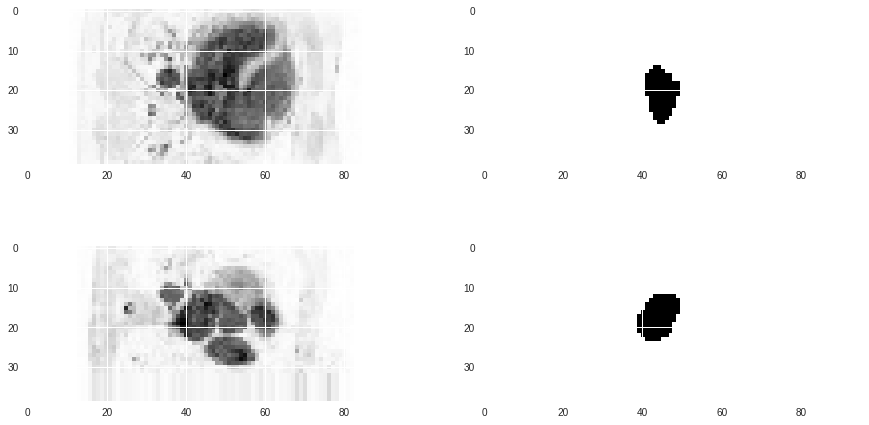

In [6]:
plt_slice = 48

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.imshow(fixed_image[0,0,:,plt_slice,:])
plt.subplot(222)
plt.imshow(fixed_label[0,0,:,plt_slice,:])
plt.subplot(223)
plt.imshow(moving_image[0,0,:,plt_slice,:])
plt.subplot(224)
plt.imshow(moving_label[0,0,:,plt_slice,:])

#### TODO: write a dice evaluation function: 
# takes two label images as inputs and returns their dice overlap value

def dice_val(f_label, m_label):
  # compute numerator
  numerator = 0.0 # TODO
  # compute denominator
  denominator = 1.0 # TODO
  return numerator / denominator


dice_init = dice_val(fixed_label, moving_label)
print('Dice init: ', dice_init)

Now, we want to register the images.

Given a pair of images $(\mathcal{F}, \mathcal{M})$, where the moving image $\mathcal{M}$ should be aligned with the fixed image $\mathcal{F}$, we formulate this problem as 
\begin{equation}
    argmin_{\varphi} ~ \mathcal{D}(\mathbf{S}_{\mathcal{F}}, \varphi\circ\mathbf{S}_{\mathcal{M}}) + \alpha\mathcal{R}(\varphi)
\end{equation}

i.e. we search the transformation $\varphi$, that best transforms $\mathbf{S}_{\mathcal{M}}$ towards $\mathbf{S}_{\mathcal{F}}$. 

Note that

1.    $\mathbf{S}_{\mathcal{M/F}}$ denote representations of $\mathcal{M/F}$. If $\mathbf{S}$ is the identity, the images are represented by their greyvalues themselves. Here, we will use the *MIND* descriptor as image representation, which would also be capable of handling multi-modal images.
2.  $ \mathcal{D}(\cdot)$ penalizes dissimilarities, e.g. when choosing the *Sum of Squared Differences* (SSD) as measure, we would prefer small differences between at every image position when comparing $\mathbf{S}_{\mathcal{F}}(\mathbf{x})$ and $(\varphi\circ\mathbf{S}_{\mathcal{F}})(\mathbf{x})$.
3.  weighted by a scalar $\alpha$, $\mathcal{R}(\varphi)$ penalizes implausible transformations, i.e. folding or abrupt changes in deformation field values for neighboring positions.

This leaves the following tasks to do:


1.   Compute the *MIND* representations of the fixed and moving images.
2.   Define a similarity measure function.
3.   Define the regularizer as a function.
4.   Optimize the transformation parameters.




1. Compute the *MIND* features.

In [8]:
def MINDSSC3d(img_in,theta_ssc,kernel_hw):
    C = theta_ssc.size(1)
    H = img_in.size(2); W = img_in.size(3); D = img_in.size(4)
    grid_x, grid_y, grid_z = torch.meshgrid((torch.linspace(-1,1,H),torch.linspace(-1,1,W),torch.linspace(-1,1,D)))
    grid_x = grid_x.contiguous();grid_y = grid_y.contiguous();grid_z = grid_z.contiguous()
    grid_xyz = torch.stack((grid_z.view(1,1,-1,1),grid_y.view(1,1,-1,1),grid_x.view(1,1,-1,1)),4).cuda()

    sampled = F.grid_sample(img_in,grid_xyz + theta_ssc[0,:,:].view(1,-1,1,1,3)).view(1,C,H,W,D)
    sampled -= F.grid_sample(img_in,grid_xyz + theta_ssc[1,:,:].view(1,-1,1,1,3)).view(1,C,H,W,D)
    mind = F.avg_pool3d(torch.abs(sampled)**2,kernel_hw*2+1,stride=1,padding=kernel_hw)
    mind -= torch.min(mind,1,keepdim=True)[0]   
    mind /= (torch.sum(mind,1,keepdim=True)+0.001)
    mind = torch.exp(-mind)
    del sampled; del grid_xyz
    torch.cuda.empty_cache()
    return mind

with torch.no_grad():
  delta = 1
  d = delta*3.0
  H = fixed_image.size(2); W = fixed_image.size(3); D = fixed_image.size(4)
  theta_ssc = torch.Tensor(2,12,3)
  # 1=-H, 2=-D, 3=+W, 4=-W, 5=+D, 6=+H
  # 1,1,2,2,3,3,4,4,5,5,6,6,
  # 2,3,4,6,2,5,1,5,1,6,4,3,
  theta_ssc[0,:,0] = torch.Tensor([-d,-d, 0, 0, 0, 0, 0, 0, 0, 0,+d,+d])/H 
  theta_ssc[0,:,1] = torch.Tensor([ 0, 0, 0, 0,+d,+d,-d,-d, 0, 0, 0, 0])/W
  theta_ssc[0,:,2] = torch.Tensor([ 0, 0,-d,-d, 0, 0, 0, 0,+d,+d, 0, 0])/D

  theta_ssc[1,:,0] = torch.Tensor([ 0, 0, 0,+d, 0, 0,-d, 0,-d,+d, 0, 0])/H
  theta_ssc[1,:,1] = torch.Tensor([ 0,+d,-d, 0, 0, 0, 0, 0, 0, 0,-d,+d])/W
  theta_ssc[1,:,2] = torch.Tensor([-d, 0, 0, 0,-d,+d, 0,+d, 0, 0, 0, 0])/D

  theta_ssc = nn.Parameter(theta_ssc+torch.randn(2,12,3)*0.00).cuda()
  kernel_hw = 2
  
  ###### TODO compute MIND features; maybe on the GPU?
  # insert the correct tensors....
  fixed_feat = MINDSSC3d(torch.zeros(1,1,25,25,25).cuda(),theta_ssc,kernel_hw)
  moving_feat = MINDSSC3d(torch.zeros(1,1,25,25,25).cuda(),theta_ssc,kernel_hw)
  
  print(fixed_feat.size())
  print(moving_feat.size())

torch.Size([1, 12, 25, 25, 25])
torch.Size([1, 12, 25, 25, 25])


Visualization of a *MIND* slice

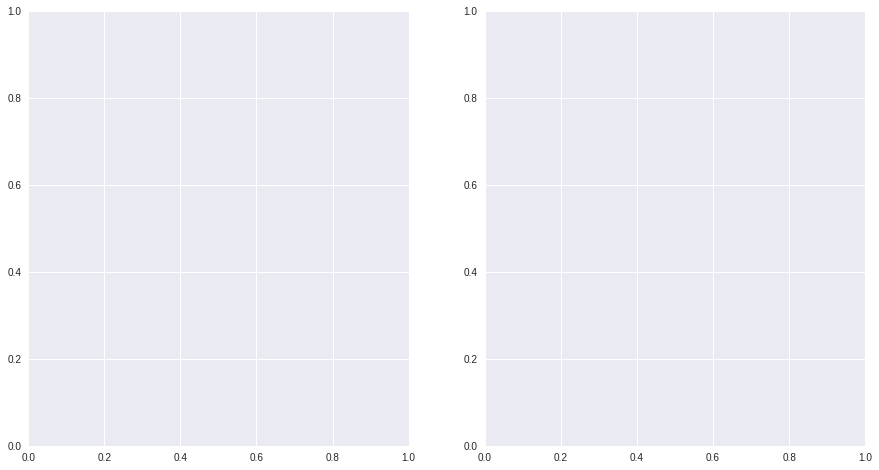

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(121)
#plt.imshow(f)
plt.subplot(122)
#plt.imshow()

2. Define a loss function: in the *MIND* case its simple, we can use the *Sum of Absolute Distances* (SAD)

In [0]:
sim_measure = # look for one of pytorchs loss functions -> that is equivalently to SAD

3. Define the regularizer:

In [0]:
# implement beding energy regularisation

# finite difference operation is given for dFdx
# TODO: dFdy, dFdz

def dFdx(field):
    # expects a flowfield : 1xDxHxWx3 -> last dim: x,y,z
    # computes per component derivative (last 3 components in x_dir)
    # and clips it accordingly in the other dimensions, so the size will be diminished by 2 equally
    dx = (field[:,2:,1:-1,1:-1,0] - field[:,:-2,1:-1,1:-1,0]) / 2.0
    dy = (field[:,1:-1,2:,1:-1,0] - field[:,1:-1,:-2,1:-1,0]) / 2.0
    dz = (field[:,1:-1,1:-1,2:,0] - field[:,1:-1,1:-1,:-2,0]) / 2.0
    return torch.stack((dx,dy,dz),dim=4)



class BendingEnergyReg(torch.nn.Module):
    def __init__(self):
        super(BendingEnergyReg, self).__init__()
    
    def forward(self, field):
        # compute dx, dy, dz
        dx = dFdx(field)
        dy = #....
        dz = #....
        
        # second derivatives & mixed terms
        dxx = #....
        dyy = #....
        dzz = #....
        dxy = #....
        dyz = #....
        dxz = #....
        
        # putting it all together
        penalty = torch.sum(dxx**2 + dyy**2 + dzz**2 + 2.0*(dxy**2 + dyz**2 + dxz**2))
        
        return penalty * (1.0/torch.numel(dxx))

Build the registration optimization process:
- Define functions to transform the moving image and label
- Define the transformation grid as parameters that have to be backpropagated into & updated
- Use a coarse grid & employ B-Spline interpolation methods to upsample it again
- For several iterations, update the parameter tensor with the Adam optimizer

In [0]:
def img_warp(img, id_field, param_field):
  # expects the image to warp, the full resolution identity field
  # and the coarser param_field containing the displacments
  
  # 1) upsamples the coarse grid to the same resolution as the image resolution
  param_field = param_field.permute(0, 4, 1, 2, 3)
  param_field = torch.nn.functional.interpolate(param_field,
                                                size=(img.size(2), img.size(3), img.size(4)),
                                                mode='trilinear', align_corners=True)
  # 2) smoothes the field... (also a kind of regularisation)
  smoother = torch.nn.Sequential(torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2),
                                 torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2),
                                 torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2))
  param_field = smoother(param_field)
  param_field = param_field.permute(0, 2, 3, 4, 1)
  # 3) employing grid_sampler to interpolate off-grid image values
  warped = torch.nn.functional.grid_sample(img, param_field + id_field,
                                           padding_mode="border")
  return warped

def label_warp(img, id_field, param_field):
  # same as above, but the grid_sampling uses nearest neighbor interpolation
  # to preserve labels -> no interpolation between 0 & 1 e.g. and "adding"
  # false labels as 0.5
  param_field = param_field.permute(0, 4, 1, 2, 3)
  param_field = torch.nn.functional.interpolate(param_field,
                                                size=(img.size(2), img.size(3), img.size(4)),
                                                mode='trilinear', align_corners=True)
  smoother = torch.nn.Sequential(torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2),
                                 torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2),
                                 torch.nn.AvgPool3d(kernel_size=5, stride=1, padding=2))
  param_field = smoother(param_field)
  param_field = param_field.permute(0, 2, 3, 4, 1)
  warped = torch.nn.functional.grid_sample(img, param_field + id_field,
                                           padding_mode="border",
                                           mode='nearest') # HERE: nearest neighbor
  return warped

In [11]:
# define the coarse parameter grid -> identity field at first
with torch.no_grad():
  sub_factor = # choose a coarser grid factor 
  
  s0 = fixed_image.size(2)
  s1 = fixed_image.size(3)
  s2 = fixed_image.size(4)

  s0_sub = int(s0 / sub_factor)
  s1_sub = int(s1 / sub_factor)
  s2_sub = int(s2 / sub_factor)


  m0, m1, m2 = torch.meshgrid(torch.linspace(-1,1,s0),
                                          torch.linspace(-1,1,s1),
                                          torch.linspace(-1,1,s2))
  
  id_field = torch.stack((m2, m1, m0), dim=3).unsqueeze(0)
  
with torch.enable_grad():
  # this is the parameter tensor
  displ = torch.zeros(1, s0_sub, s1_sub, s2_sub, 3)
  print(displ.size())
  
  # set number of registration iterations
  reg_iters = #... set a number
  reg_regul = BendingEnergyReg()
  alpha = #... 
  
  # track the loss evolution
  sim_evo = torch.zeros(reg_iters, requires_grad=False)
  regul_evo = torch.zeros(reg_iters, requires_grad=False)
  
  # register the parameters with the optimizer
  displ = displ.cuda()
  displ = torch.nn.Parameter(displ)
  reg_adam = torch.optim.Adam([displ], lr=0.000) # set a suitable initial lr
  
  # move inputs to the GPU
  id_field = id_field.cuda().detach()
  fixed_feat = fixed_feat.cuda().detach()
  moving_feat = moving_feat.cuda().detach()
  
  # instantiate a prograss bar for visualization...
  f = IntProgress(min=0, max=reg_iters) 
  display(f) # display the bar
  
  
  for rdx in range(reg_iters):
    
    reg_adam.zero_grad()
    
    warped_feat = # insert the correct warping function with suitable inputs
    
    similarity_val = # compute the similarity value
    regularizer_val = # compute the regularization value
    optim_val = similarity_val + regularizer_val
    
    # let autograd do the backpropagation for you...
    optim_val.backward()
    # ... and adam the optimisation!
    reg_adam.step()
    
    # plot the progress
    sim_evo[rdx] = similarity_val.item()
    regul_evo[rdx] = regularizer_val.item()
    f.value += 1 # signal to increment the progress bar
   
  # display the registration 
  plt.figure()
  plt.plot(sim_evo.numpy(),label='Similarity')
  plt.plot(regul_evo.numpy(),label='Regularizer')
  plt.legend()
  
  

SyntaxError: ignored

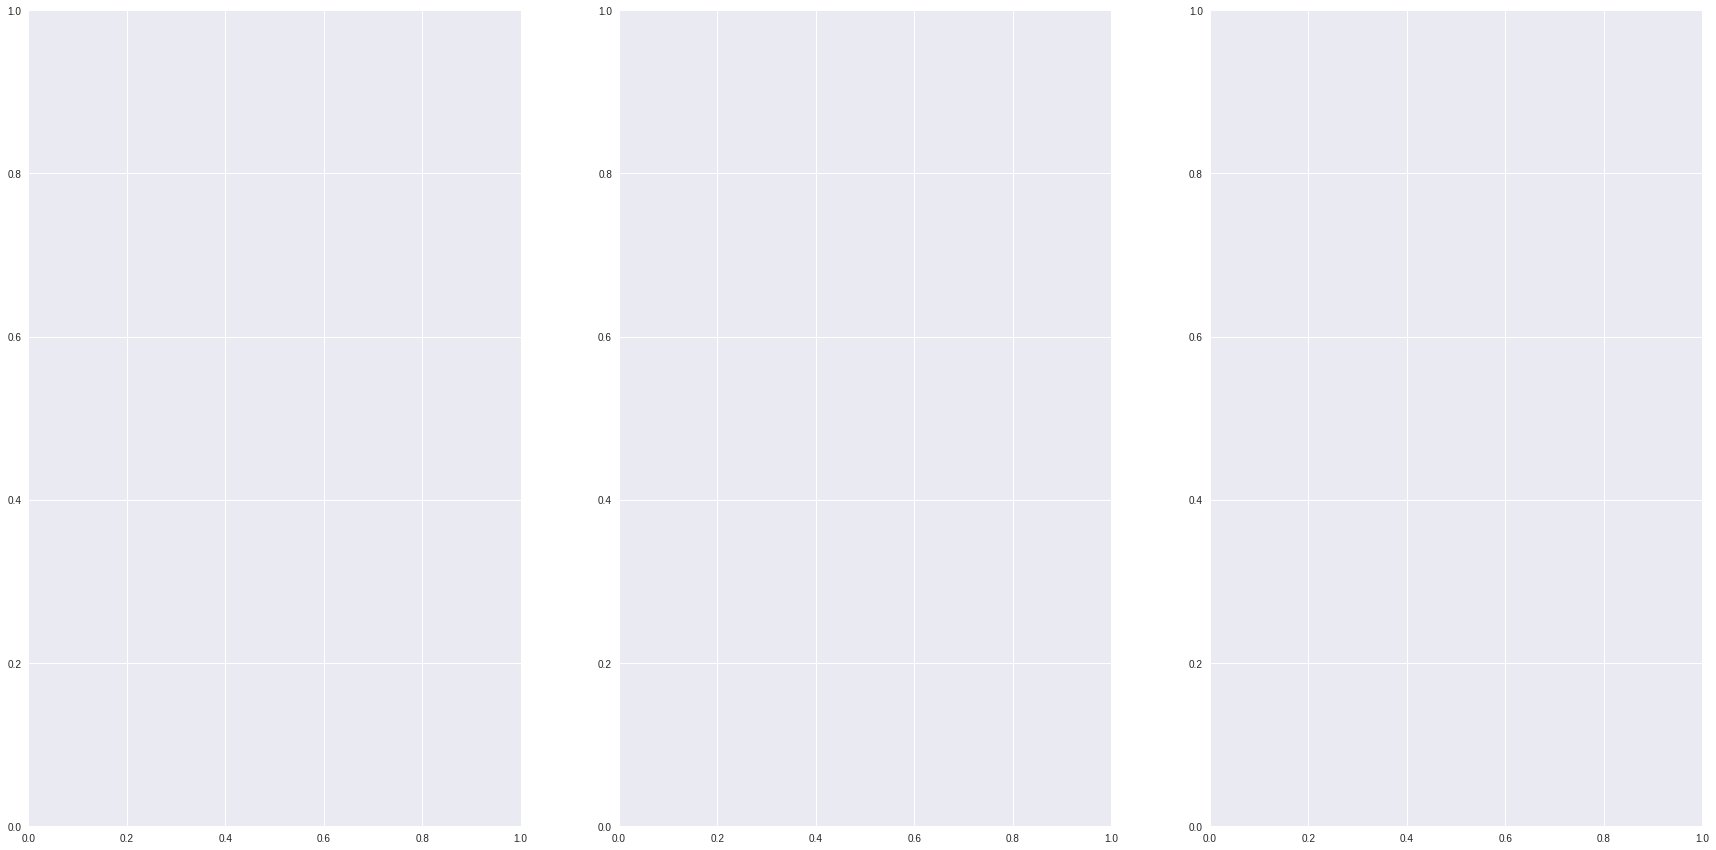

In [12]:

plt.figure(figsize=(30,15))
plt.subplot(131)
#plt.imshow(moving_feat[0,0,:,plt_slice,:].detach().cpu())
plt.subplot(132)
#plt.imshow(warped_feat[0,0,:,plt_slice,:].detach().cpu())
plt.subplot(133)
#plt.imshow(fixed_feat[0,0,:,plt_slice,:].cpu().detach())

check the result (DICE)

In [13]:
with torch.no_grad():
  
  # illustrate the results
  warped_label = # warp the label image according to the optimized displacements
  warped_image = # warp the CT image according to the optimized displacements
  
  dice_reg = dice_val(fixed_label, warped_label)
  print('Dice init:', dice_init)
  print('Dice reg :', dice_reg)
  
  # choose a plot slice: 
  plt_slice = #
  
  plt.figure(figsize=(15,8))
  plt.subplot(321)
  plt.imshow(moving_image[0,0,:,plt_slice,:])
  plt.subplot(322)
  plt.imshow(moving_label[0,0,:,plt_slice,:])
  plt.subplot(323)
  plt.imshow(warped_image[0,0,:,plt_slice,:])
  plt.subplot(324)
  plt.imshow(warped_label[0,0,:,plt_slice,:])
  plt.subplot(325)
  plt.imshow(fixed_image[0,0,:,plt_slice,:])
  plt.subplot(326)
  plt.imshow(fixed_label[0,0,:,plt_slice,:])

SyntaxError: ignored

check the resulting fields plausibility

In [14]:
# check the jacobian, e.g. number of negative jacobian entries (folding)

def jacobian_determinant_3d(dense_flow):
    B,_,H,W,D = dense_flow.size()
    
    dense_pix = dense_flow.to(dense_flow.device).flip(1)/(torch.Tensor([H-1,W-1,D-1])/2).view(1,3,1,1,1)
    gradz = nn.Conv3d(3,3,(3,1,1),padding=(1,0,0),bias=False,groups=3)
    gradz.weight.data[:,0,:,0,0] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    gradz.to(dense_flow.device)
    grady = nn.Conv3d(3,3,(1,3,1),padding=(0,1,0),bias=False,groups=3)
    grady.weight.data[:,0,0,:,0] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    grady.to(dense_flow.device)
    gradx = nn.Conv3d(3,3,(1,1,3),padding=(0,0,1),bias=False,groups=3)
    gradx.weight.data[:,0,0,0,:] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    gradx.to(dense_flow.device)
    with torch.no_grad():
        jacobian = torch.cat((gradz(dense_pix),grady(dense_pix),gradx(dense_pix)),0)+torch.eye(3,3).view(3,3,1,1,1).to(dense_flow.device)
        jacobian = jacobian[:,:,2:-2,2:-2,2:-2]
        jac_det = jacobian[0,0,:,:,:]*(jacobian[1,1,:,:,:]*jacobian[2,2,:,:,:]-jacobian[1,2,:,:,:]*jacobian[2,1,:,:,:])-\
        jacobian[1,0,:,:,:]*(jacobian[0,1,:,:,:]*jacobian[2,2,:,:,:]-jacobian[0,2,:,:,:]*jacobian[2,1,:,:,:])+\
        jacobian[2,0,:,:,:]*(jacobian[0,1,:,:,:]*jacobian[1,2,:,:,:]-jacobian[0,2,:,:,:]*jacobian[1,1,:,:,:])

    return jac_det


dense_field = torch.nn.functional.interpolate(displ.permute(0,4,1,2,3),
                                              size=(id_field.size(1), id_field.size(2), id_field.size(3)),
                                              mode='trilinear', align_corners=True).permute(0,2,3,4,1)

jac_det = jacobian_determinant_3d((id_field+dense_field).cpu().permute(0,4,1,2,3))

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

neg_frac = torch.mean((jac_det<0).float())
print('%0.3f'%(jac_det.std()),'%0.3f'%(neg_frac))

NameError: ignored

*Additional* task for those of you that are really fast:

use **your own trained UNet**-Encoder as feature_images and try to register the images based on this representation below!

In [0]:
# copy paste the loop above and change it to suit your needs.
# also generate the UNet feature representations of the fixed and moving image